In [20]:
%pylab
%matplotlib inline 
import pandas as pd
import matplotlib.cm as cm

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [7]:
def get_data():
        filename = '../data/r16_table4.out'
        sne_start = 40
        sne_end = 59
        sne_lines = arange(sne_start,sne_end)
        sne = pd.DataFrame(columns = ['Host', 'sne', 'm^B_0', 'err'], index = arange(sne_end - sne_start))
        ceph_start = 70
        ceph_end = 2346
        cepheid_lines = arange(ceph_start,ceph_end)
        cepheids = pd.DataFrame(columns = ['Field','RA','DEC','ID','Period','VminusI','m_H','sigma_tot','Z'], 
                                index = arange(ceph_end - ceph_start),
                               dtype = 'float')
        f = file(filename)
        for i, line in enumerate(f):
            if i in sne_lines:
                sne.loc[i-sne_start] = line.lower().split()
            if i in cepheid_lines:
                cepheids.loc[i-ceph_start] = line.lower().split()

        f.close()
        cepheids = cepheids.apply(lambda x: pd.to_numeric(x, errors='ignore') );

        sne = sne.apply(lambda x: pd.to_numeric(x, errors='ignore') );
        
        
        parallaxes = {'bgcru': (2.23, 0.30,-0.15), 
                      'dtcyg':(2.19,0.33, -0.18), 
                      'ffaql':(2.64,0.16, -0.03),
                      'rtaur':(2.31, 0.19,-0.06),
                      'sscma':(0.348, 0.038, -0.04),
                      'sucas':(2.57,  0.33, -0.13 ),
                      'syaur':(0.428, 0.054, -0.04),
                      'tvul':(2.06,0.22,-0.09 ),
                      'wsgr':(2.30, 0.19, -0.06),
                      'xsgr':(3.17, 0.14, -0.02),
                      'ysgr':(2.13, 0.29, -0.15),
                      'betador':(3.26, 0.14, -0.02),
                      'delceph':(3.71,0.12,-0.01),
                      'etagem':(2.74,0.12,-0.02),
                      'lcar':(2.03,0.16,-0.05)
                     }
        parallaxes = pd.DataFrame.from_dict(parallaxes, orient = 'index', )
        parallaxes.reset_index(inplace=True)
        parallaxes.columns = ['ID', 'parallax', 'p_err', 'LK']
        cepheids = cepheids.merge(parallaxes, on = 'ID', how = 'left')
        

        cepheids.fillna({'parallax':1e-03, 'p_err':0, 'LK':0}, inplace = True);
        cepheids['err'] = sqrt(cepheids.sigma_tot**2 + (cepheids.p_err / cepheids.parallax * 5/log(10))**2)
        return cepheids, sne

In [89]:
cepheids, sne = get_data()
#cepheids = cepheids[cepheids.VminusI <2]

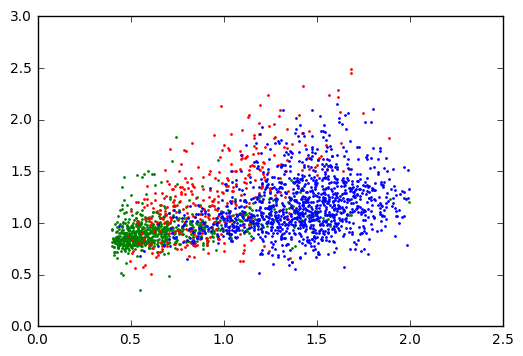

In [90]:
lmc = cepheids[cepheids.Field == 'lmc']
m31 = cepheids[cepheids.Field == 'm31']
others = cepheids[(cepheids.Field != 'lmc') & (cepheids.Field != 'm31')]
scatter(log10(lmc['Period']), lmc['VminusI'], color = 'g', s = 1)
scatter(log10(m31['Period']), m31['VminusI'], color = 'r', s = 1)
scatter(log10(others['Period']), others['VminusI'], color = 'b', s = 1)


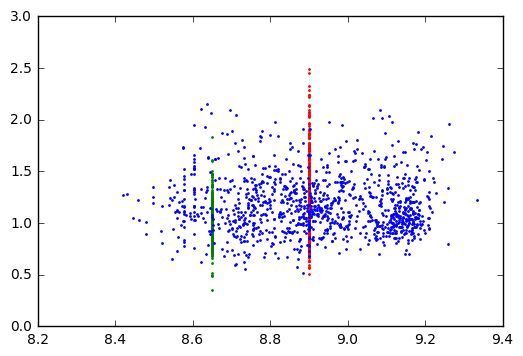

In [91]:
scatter(lmc['Z'], lmc['VminusI'], color = 'g', s = 1)
scatter(m31['Z'], m31['VminusI'], color = 'r', s = 1)
scatter(others['Z'], others['VminusI'], color = 'b', s = 1)


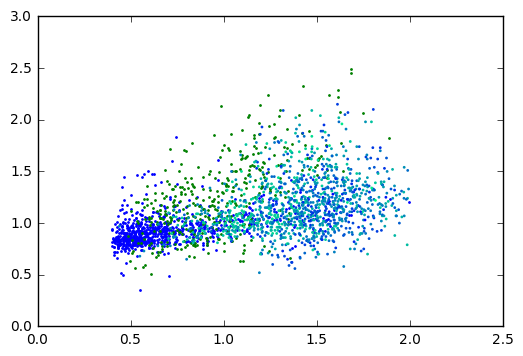

In [92]:
scatter(log10(lmc['Period']), lmc['VminusI'], color = 'b', s = 1)
scatter(log10(m31['Period']), m31['VminusI'], color = 'g', s = 1)
scatter(log10(others['Period']), others['VminusI'], color = cm.winter((others['Z']-8.42)/0.914), s = 1)

In [97]:
def residual(params):
    result =  cepheids.VminusI - ((log10(cepheids.Period) - 1)*((params[0]*(cepheids.Period < 10))
                                                                + (params[0]*(cepheids.Period >= 10))
                                                                )
                               + params[2] * ((cepheids.Z) - 8.9) 
                               + params[3])
    return result

In [98]:
from scipy.optimize import leastsq

x, cov = leastsq(residual, (0,0,0, mean(cepheids.VminusI),),)

In [99]:
x

array([ 0.28858779,  0.        ,  0.18612632,  1.09216443])

(0.4, 2)

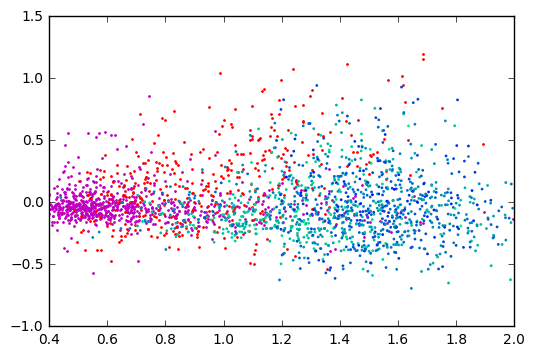

In [100]:
scatter(log10(lmc['Period']), 
        residual(x)[cepheids.Field == 'lmc'],
        color = 'm', s = 1)
scatter(log10(m31['Period']), 
        residual(x)[cepheids.Field == 'm31'],
        color = 'r', s = 1)
scatter(log10(others['Period']), 
        residual(x)[(cepheids.Field != 'm31') & (cepheids.Field != 'lmc')], 
        color = cm.winter((others['Z']-8.42)/0.914), s = 1)
#ylim(-0.5, 0.5)
xlim(0.4, 2)